### Train a model on the balanced dataset

In [0]:
# # Run once to install
# !pip install image-classifiers==0.2.2
# !pip install image-classifiers==1.0.0b1
# !pip install imgaug

In [0]:
# import keras
# print(keras.__version__)

In [1]:
import sys
# !{sys.executable} -m pip install tensorflow==1.13.1
# tensorflow==1.13.1
# keras==2.2.4
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

%tensorflow_version 1.x

import tensorflow
import keras
print(tensorflow.__version__)
print(keras.__version__)

import tensorflow as tf
tf.test.gpu_device_name()


TensorFlow 1.x selected.


Using TensorFlow backend.


1.15.2
2.3.1


'/device:GPU:0'

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')


In [3]:
# Import libs
import os 
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
import keras
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from keras.models import Sequential
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils import np_utils
from imgaug import augmenters as iaa    
import itertools

np.random.seed(42)

# Print version
print("Keras Version", keras.__version__)
print("Tensorflow Version", tf.__version__)


# GPU test
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

# Get compute specs
from tensorflow.python.client import device_lib
device_lib.list_local_devices()



# Helpers functions

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)


def plot_hist(img):
    
    img_flat = img.flatten()
    print(min(img_flat), max(img_flat))
    
    plt.hist(img_flat, bins=20, color='c')
    plt.title("Data distribution")
    plt.xlabel("Pixel values")
    plt.grid(True)
    plt.ylabel("Frequency")
    
    plt.show()



from keras import backend as K
import tensorflow as tf


# Define paths
base_path = os.path.abspath("../")
# '/content/gdrive/My Drive/adversarial-xray/'
dataset_path = os.path.join(base_path, "dataset", "dataNumpy")
print(os.listdir(dataset_path))


# Load data
x_train = np.load("{}/x_upsampled.npy".format(dataset_path)) 
y_train = np.load("{}/y_upsampled.npy".format(dataset_path))
x_test = np.load("{}/x_test.npy".format(dataset_path))
y_test = np.load("{}/y_test.npy".format(dataset_path))


# Shuffle training dataset
flag = 1
if flag == 1:
    # Shuffle data
    print("Shuffling data")
    s = np.arange(x_train.shape[0])
    np.random.shuffle(s)
    x_train = x_train[s]
    y_train = y_train[s]
else:
    print("Not shuffling...")
    pass



# Show shape
print("Dataset sample size :", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# check on training data
#img = x_train[0]
#plot_hist(img)

#plt.imshow(x_train[0])

Keras Version 2.3.1
Tensorflow Version 1.15.2
['/device:GPU:0']
['x_train.npy', 'y_train.npy', 'x_train_gan.npy', 'y_train_gan.npy', 'y_test.npy', 'x_test.npy', 'x_upsampled.npy', 'y_upsampled.npy', 'x_train_gan_p.npy', 'y_train_gan_p.npy', 'y_upsampled_.npy', 'x_upsampled_.npy', 'testX.npy', 'testY.npy']
Shuffling data
Dataset sample size : (3219, 256, 256, 3) (3219, 3) (580, 256, 256, 3) (580, 3)


In [4]:
import keras
from keras.layers import Input

# preprocessing
prepro = False 

if prepro == True:
    print("Preprocessing training data")
    x_train = x_train.astype('float32')
    x_train /= 255
else:
    print("Not preprocessing training data, already preprocessed in generator.")
    pass

# Standardize test set
x_test = x_test.astype('float32')
x_test /= 255

print(x_train.shape, x_test.shape)

# check on preprocessed data
#img = x_test[0]
#plot_hist(img)
#plt.imshow(x_test[0])

Not preprocessing training data, already preprocessed in generator.
(3219, 256, 256, 3) (580, 256, 256, 3)


In [5]:
# Experiment name
EXP_NAME = "results_after_GAN"

# Create folder for the experiment
create_directory("{}/{}".format(base_path, EXP_NAME))
output_path = os.path.join(base_path, EXP_NAME)


# Callbacks
weights_path = "{}/{}.h5".format(output_path, EXP_NAME)
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-8, mode='auto') # new_lr = lr * factor
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=8, mode='auto', restore_best_weights=True)
csv_logger = CSVLogger('{}/{}_training.csv'.format(output_path, EXP_NAME))


# Define class weights for imbalacned data
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(None, np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
print(class_weights)


def our_model():

    # Get backbone network
    input_tensor = Input(shape=(256, 256, 3))  

    base_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

    # Add GAP layer
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    # Add FC layer
    output = keras.layers.Dense(3, activation='softmax', trainable=True)(x) 

    # Build model
    model = keras.models.Model(inputs=[base_model.input], outputs=[output])

    # Optimizers
    adadelta = optimizers.Adadelta(lr=0.001) 

    # Compile
    model.compile(optimizer=adadelta, loss= 'categorical_crossentropy', metrics=['accuracy']) 

    # Output model configuration
    model.summary()

    return model


model = None
model = our_model()

[1. 1. 1.]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (Non

In [7]:
# Train the model
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

# Configuration
batch_size = 16
epochs = 100 

# Calculate the starting time    
start_time = time.time()


model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            class_weight = class_weights,
            callbacks=[csv_logger, early_stopping, reduce_lr, checkpointer], # early_stopping, checkpointer, reduce_lr
            shuffle=True)


end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))



Train on 2060 samples, validate on 515 samples
Epoch 1/100
2060/2060 [==============================] - 22s 11ms/step - loss: 1.0600 - accuracy: 0.4655 - val_loss: 0.9171 - val_accuracy: 0.7709

Epoch 00001: val_loss improved from inf to 0.91713, saving model to /content/gdrive/My Drive/adversarial-xray/results_after_GAN_p/results_after_GAN_p.h5
Epoch 2/100
2060/2060 [==============================] - 21s 10ms/step - loss: 0.7040 - accuracy: 0.8117 - val_loss: 0.4425 - val_accuracy: 0.8854

Epoch 00002: val_loss improved from 0.91713 to 0.44248, saving model to /content/gdrive/My Drive/adversarial-xray/results_after_GAN_p/results_after_GAN_p.h5
Epoch 3/100
2060/2060 [==============================] - 21s 10ms/step - loss: 0.3813 - accuracy: 0.8646 - val_loss: 0.3847 - val_accuracy: 0.8621

Epoch 00003: val_loss improved from 0.44248 to 0.38467, saving model to /content/gdrive/My Drive/adversarial-xray/results_after_GAN_p/results_after_GAN_p.h5
Epoch 4/100
2060/2060 [===================

In [0]:
# Save model
model.save(weights_path)

In [0]:
# Experiment name
EXP_NAME = "results_after_GAN"

# Create folder for the experiment
create_directory("{}/{}".format(base_path, EXP_NAME))
output_path = os.path.join(base_path, EXP_NAME)
weights_path = "{}/{}.h5".format(output_path, EXP_NAME)

model_after_GAN = tf.keras.models.load_model(weights_path, custom_objects={'focal_loss_fixed': focal_loss()})

In [0]:
print(weights_path)

/content/gdrive/My Drive/adversarial-xray/results_after_GAN_p/results_after_GAN_p.h5


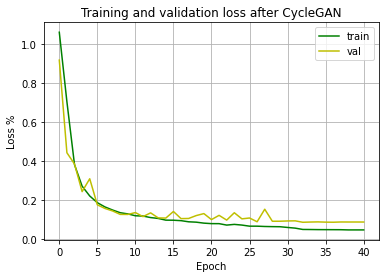

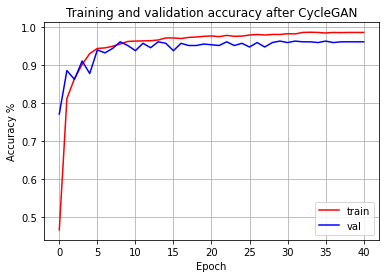

Done training and logging!


In [9]:
# Plot and save accuravy and loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training and validation loss after CycleGAN')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.show()
    
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation accuracy after CycleGAN')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_acc.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.show()

plot_loss_accu(model.history)
print("Done training and logging!")

In [10]:
# Shuffle testing dataset
flag = 1
if flag == 1:
    # Shuffle data
    print("Shuffling data")
    s = np.arange(x_test.shape[0])
    np.random.shuffle(s)
    x_test = x_test[s]
    y_test = y_test[s]
else:
    print("Not shuffling...")
    pass

Shuffling data


In [11]:
# convert one-hot-encoding to numeric labels
y_true = []
for i in range(len(y_test)):
    y_true.append(np.argmax(y_test[i], axis=None, out=None))
# print(y_true)


[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
[2, 2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 1, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 

In [12]:
# do predictions
y_pred = []
for i in range(len(x_test)):
    img = x_test[i].reshape(1, 256, 256, 3)
    # print(img.shape)
    pred_prob = model.predict(img)
    # print(pred_prob)
    # convert the probabilities to class labels
    y_pred.append(np.argmax(pred_prob, axis=None, out=None))
print(y_pred)

[2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 1, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 

In [13]:
# Importing the dependancies
from sklearn import metrics
# Printing the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred))


[[264   0   4]
 [  1  41   2]
 [ 12   3 253]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       268
           1       0.93      0.93      0.93        44
           2       0.98      0.94      0.96       268

    accuracy                           0.96       580
   macro avg       0.95      0.95      0.95       580
weighted avg       0.96      0.96      0.96       580



In [0]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('{}/{}_cm.jpeg'.format(output_path, EXP_NAME), dpi=300)
    plt.show()


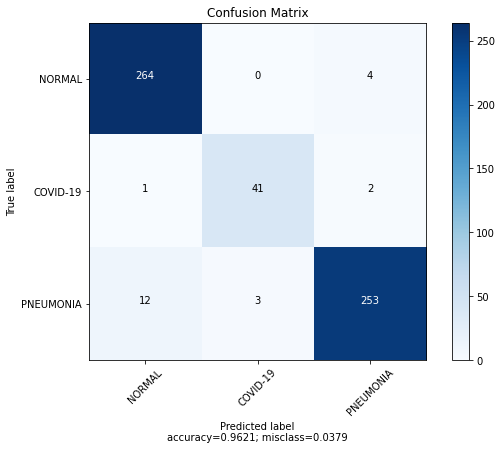

In [15]:
cm = metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['NORMAL', 'COVID-19', 'PNEUMONIA'],
                      title        = "Confusion Matrix")
